**This course was made with the help of Rita Peixoto**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import os
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import models
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

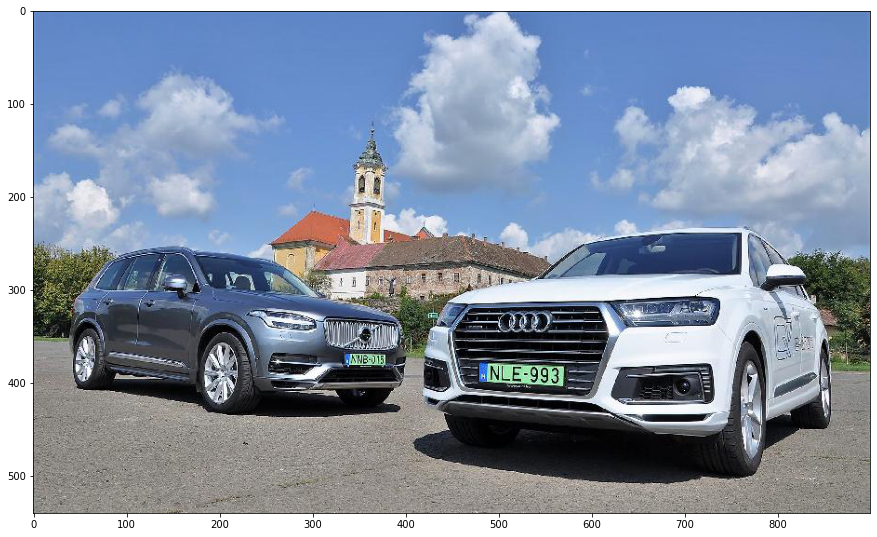

In [2]:
img = matplotlib.image.imread("sm_DSC_2144.jpg")
plt.figure(figsize=(15,15))
imgplot = plt.imshow(img)
plt.show()

### Edge detection kernel

In [3]:
mat = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

In [4]:
r = signal.convolve2d(img[:,:,0], mat, boundary='symm', mode='same')
g = signal.convolve2d(img[:,:,1], mat, boundary='symm', mode='same')
b = signal.convolve2d(img[:,:,2], mat, boundary='symm', mode='same')

### Red

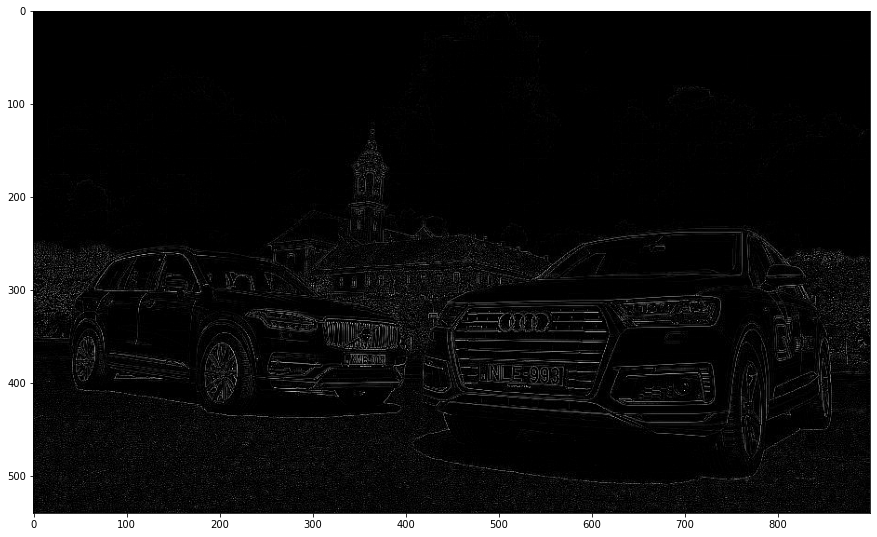

In [5]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(r*(r>0),cmap='gray')
plt.show()

### Green

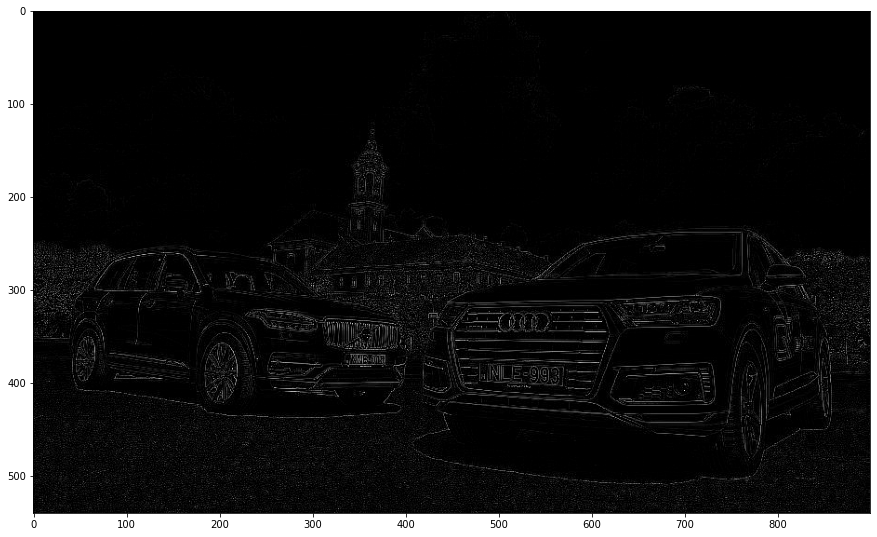

In [6]:
plt.figure(figsize=(15,15))
imgplot = plt.imshow(g*(g>0),cmap='gray')
plt.show()

### Horizontal edge detection on the blue layer

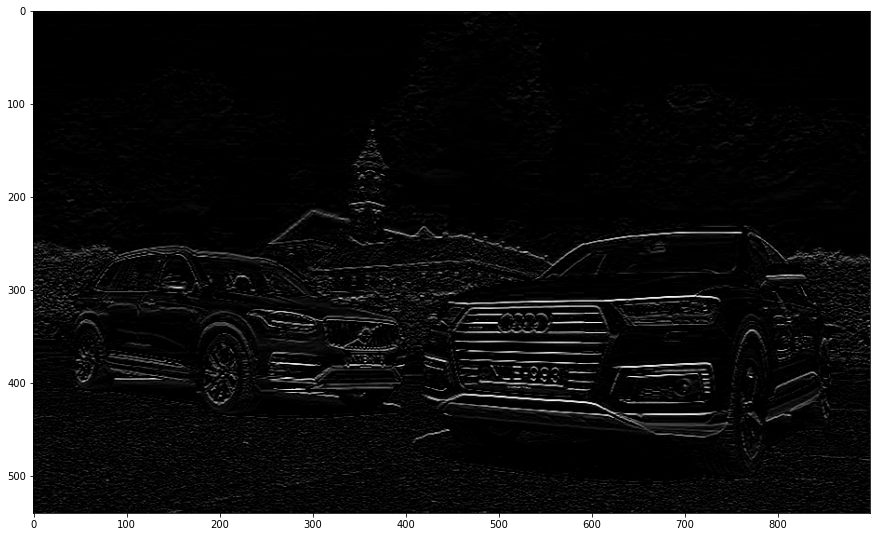

In [7]:
mat = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
b = signal.convolve2d(img[:,:,2], mat, boundary='symm', mode='same')
plt.figure(figsize=(15,15))
imgplot = plt.imshow(b*(b>0),cmap='gray')
plt.show()

### Vertical edge detection on the blue layer

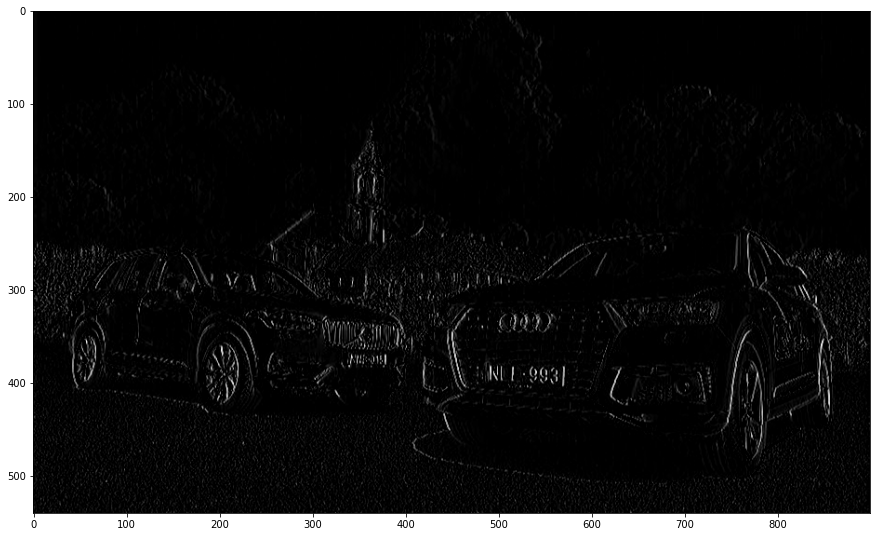

In [8]:
mat = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
b = signal.convolve2d(img[:,:,2], mat, boundary='symm', mode='same')
plt.figure(figsize=(15,15))
imgplot = plt.imshow(b*(b>0),cmap='gray')
plt.show()

## Shape detection using CNN
We will use the drawings in the zip file. Uncompress the images and if you are using colab upload it to the workspace. You cannot upload directories but uploading multiple files simulteneously works. I suggest to create the directories in the files tab using right click 'New folder'. Then go to the folder and click on the three vertical dots where you find upload.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


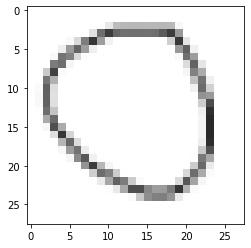

In [12]:
img = matplotlib.image.imread('drive/MyDrive/shapes/circles/drawing(1).png')
plt.imshow(img, cmap='gray');

### Read data
Walks through each file in the directory loads them into an array and sets a label

Please note that the images are grayscale, namely that RGB values are the same. We convert it back to grayscale. Then we have to add one more layer because keras conv2d expects a 4 dimensional matrix (Ndata, Len, Width, Depth)

In [13]:
def make_labels(directory, data=[], y_hat=[], label=0):
    for root, dirs, files in os.walk(directory):
        for file in files:
            img = np.reshape(cv2.cvtColor(matplotlib.image.imread(directory+file), cv2.COLOR_RGB2GRAY),(28,28,1))
            data.append(img)
        y_hat = [label] * len(data)
    return np.array(data), np.array(y_hat)

In [15]:
circles, y_circles = [], []
circles, y_circles = make_labels('drive/MyDrive/shapes/circles/', data=circles, y_hat=y_circles)

squares, y_squares = [], []
squares, y_squares = make_labels('drive/MyDrive/shapes/squares/', data=squares, y_hat=y_squares, label=1)

triangles, y_triangles = [], []
triangles, y_triangles = make_labels('drive/MyDrive/shapes/triangles/', data=triangles, y_hat=y_triangles, label=2)

In [16]:
print(circles.shape, squares.shape, triangles.shape)
print(y_circles.shape, y_squares.shape, y_triangles.shape)

(100, 28, 28, 1) (100, 28, 28, 1) (100, 28, 28, 1)
(100,) (100,) (100,)


In [17]:
X, y = np.vstack((circles, squares, triangles)), np.hstack((y_circles, y_squares, y_triangles)).reshape(-1, 1)

### Creating a convolutional neural network

In [18]:
classifier = Sequential()
# Convolution layer, with 32 random 3x3 kernels
c1 = Conv2D(32, (3,3), padding='same', input_shape = (28, 28, 1), activation = 'relu')
classifier.add(c1)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))
classifier.add(Flatten()) 
w1 = Dense(units = 25, activation = 'relu')
w2 = Dense(units = 3, activation = 'softmax')
classifier.add(w1)
classifier.add(Dropout(0.5)) 
classifier.add(w2)
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 25)                156825    
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                        

Note, that the number of parameters is `320=32*(1*3*3+1)` which is `output_channels * (input_channels * window_size + 1)`

In [24]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [25]:
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42)

In [26]:
history = classifier.fit(X_train, y_train, batch_size=40, epochs=50, verbose=1, 
                   validation_data=(X_test, y_test))

Epoch 1/50
6/6 [==============================] - 2s 142ms/step - loss: 0.7756 - accuracy: 0.6708 - val_loss: 0.8383 - val_accuracy: 0.6500
Epoch 2/50
6/6 [==============================] - 0s 31ms/step - loss: 0.6510 - accuracy: 0.7375 - val_loss: 0.8036 - val_accuracy: 0.6333
Epoch 3/50
6/6 [==============================] - 0s 29ms/step - loss: 0.6375 - accuracy: 0.7000 - val_loss: 0.7867 - val_accuracy: 0.6500
Epoch 4/50
6/6 [==============================] - 0s 33ms/step - loss: 0.6135 - accuracy: 0.7750 - val_loss: 0.7936 - val_accuracy: 0.6500
Epoch 5/50
6/6 [==============================] - 0s 33ms/step - loss: 0.5892 - accuracy: 0.7708 - val_loss: 0.8212 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.6615 - accuracy: 0.7208 - val_loss: 0.8322 - val_accuracy: 0.6333
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.5948 - accuracy: 0.7792 - val_loss: 0.7963 - val_accuracy: 0.6333
Epoch 8/50
6/6 [==========

### Plotting history of keras execution
A very useful tool which plots train and test loss and accuacy

In [17]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


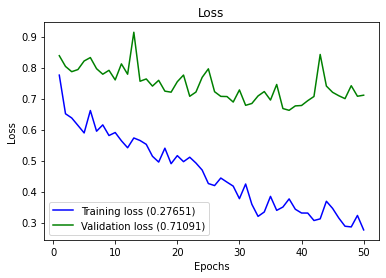

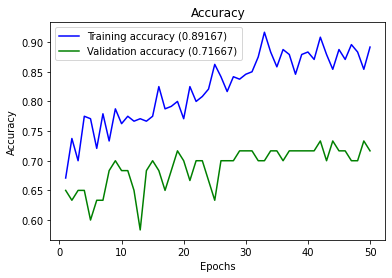

In [28]:
plot_history(history)

### Prediction

In [30]:
img = np.reshape(cv2.cvtColor(matplotlib.image.imread("drive/MyDrive/shapes/circles/drawing(1).png"), cv2.COLOR_RGB2GRAY),(28,28,1))
images = np.array([img])
classes = classifier.predict(images)
print("Prediction:",classes)
print("Predict classes:", classes.argmax(axis=1))

1/1 [==============================] - 0s 198ms/step
Prediction: [[9.9567348e-01 3.8548852e-03 4.7155833e-04]]
Predict classes: [0]


In [31]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 25)                156825    
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                        

### Plot convolution kernels

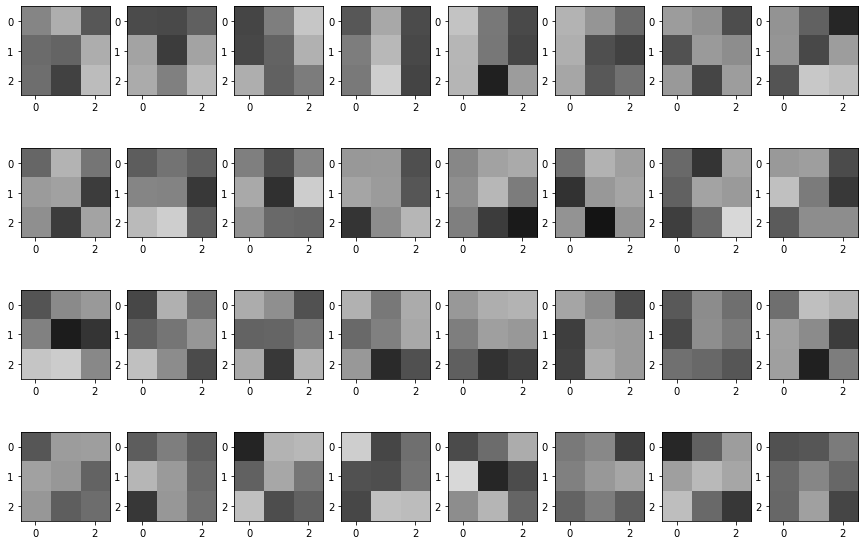

In [32]:
c1w = c1.get_weights()[0][:,:,0,:]
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(c1w[:,:,i],cmap="gray",vmin=-0.3,vmax=0.3)
plt.show()

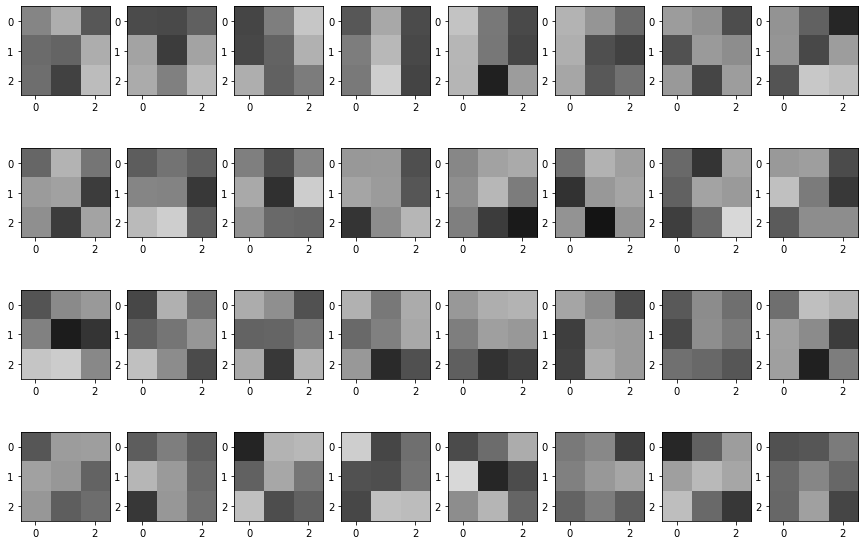

In [33]:
c1w = c1.get_weights()[0][:,:,0,:]
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(c1w[:,:,i],cmap="gray",vmin=-0.3,vmax=0.3)
plt.show()

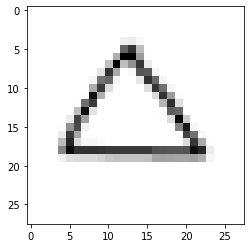

In [35]:
img = img = np.reshape(cv2.cvtColor(matplotlib.image.imread('drive/MyDrive/shapes/triangles/drawing(1).png'), cv2.COLOR_RGB2GRAY),(28,28,1))
plt.imshow(img[:,:,0], cmap='gray');

In [36]:
layer_outputs = [layer.output for layer in classifier.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [37]:
activations = activation_model.predict(np.array([img]))

1/1 [==============================] - 0s 65ms/step


In [38]:
print(np.shape(activations[1]))

(1, 14, 14, 32)


In [39]:
print(activations[0].shape)

(1, 28, 28, 32)


### Plot the result of the first layer (convolution)

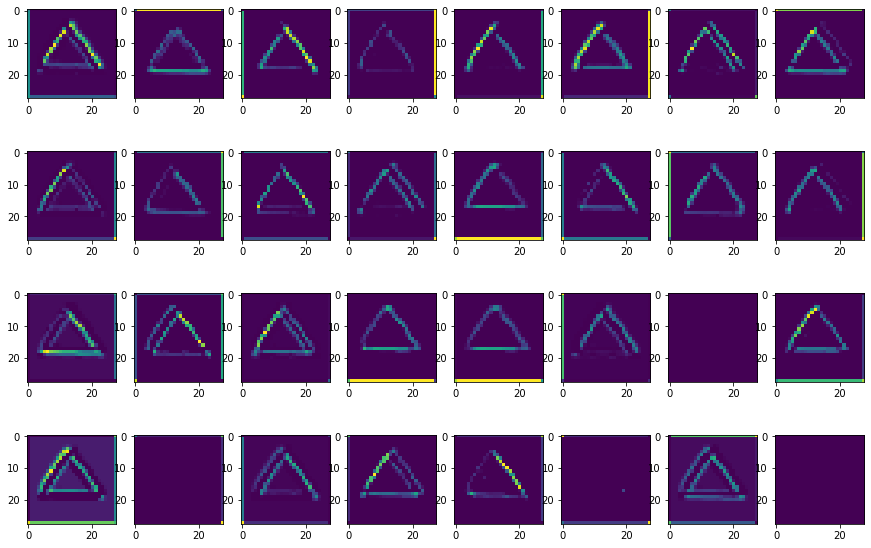

In [40]:
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(activations[0][0, :, :, i],cmap="viridis")
plt.show()

### Weights of the convolutions

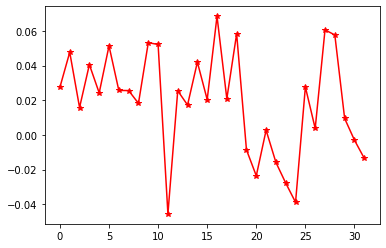

In [41]:
plt.plot(c1.get_weights()[1],"r*-")

### Unimportant convolutions results

21


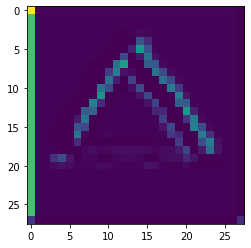

26


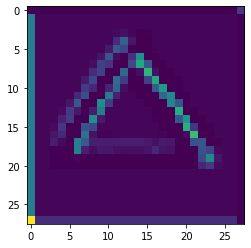

30


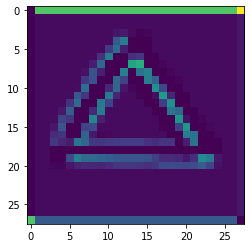

In [45]:
for i in np.where(np.abs(c1.get_weights()[1])<0.005)[0]:
    print(i)
    plt.imshow(activations[0][0, :, :, i],cmap="viridis")
    plt.show()

### Plot the result of the second layer (max pooling)

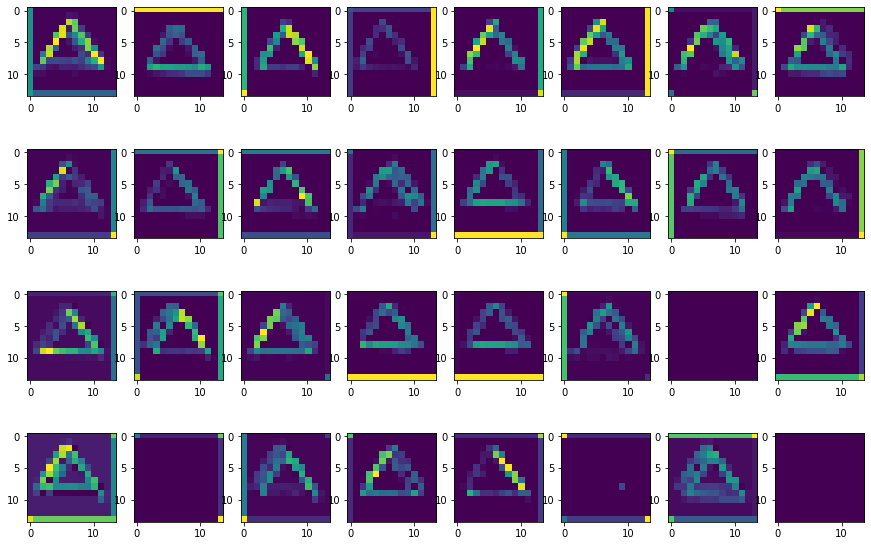

In [43]:
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(activations[1][0, :, :, i],cmap="viridis")
plt.show()

In [44]:
print(np.shape(activations[6]))

(1, 3)


### Plot the result of the third layer (dropout, dows not change anything)

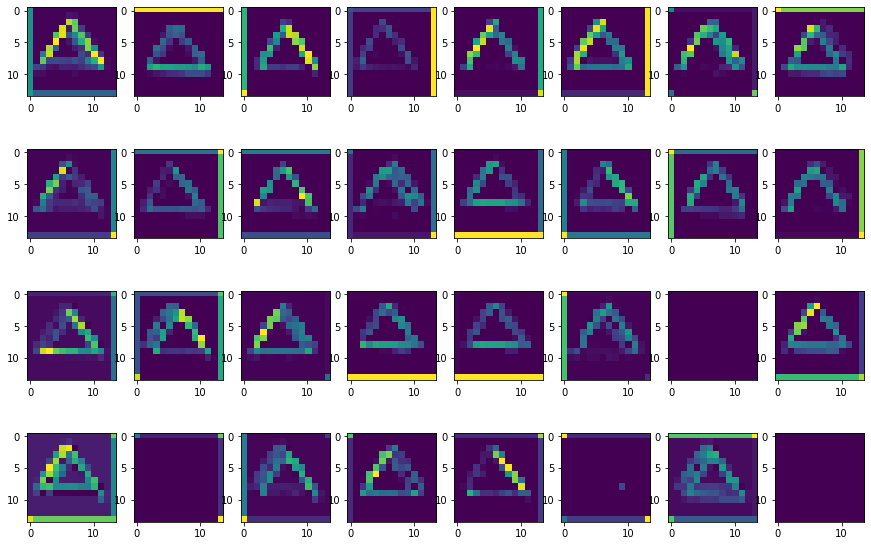

In [46]:
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(activations[2][0, :, :, i],cmap="viridis")
plt.show()

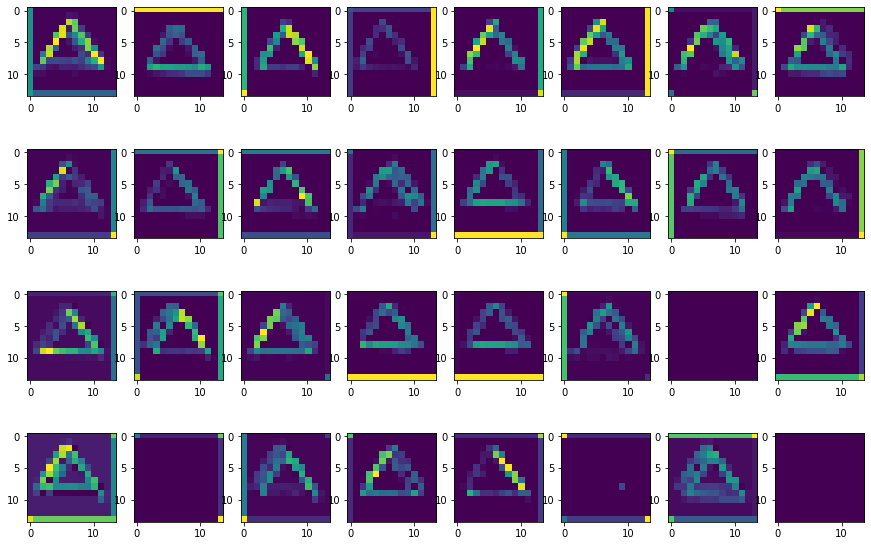

In [47]:
plt.subplots(4,8,figsize=(15,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(np.reshape(activations[3][0,:][i::32],(14,14)),cmap="viridis")
plt.show()

In [48]:
print(np.shape(activations[4]))

(1, 25)


In [49]:
print(activations[5])

[[0.95624876 0.         0.         0.         1.581717   0.
  0.         0.         0.         0.         0.         0.
  0.         0.9697955  1.3296572  0.         3.0164683  0.
  0.8918392  0.         0.         0.         0.         0.
  2.0959377 ]]


### Last dense layer

In [50]:
print(activations[6])

[[1.1917690e-02 9.5069356e-04 9.8713160e-01]]


### TASK 1
Modify the previous CNN to achieve about 90% test accuracy

In [113]:
classifier = Sequential()
# Convolution layer, with 32 random 3x3 kernels
c1 = Conv2D(32, (3,3), padding='same', input_shape = (28, 28, 1), activation = 'relu')
c2 = Conv2D(32, (3,3), padding='same', activation = 'relu')
c3 = Conv2D(32, (3,3), padding='same', activation = 'relu')
classifier.add(c1)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(c2)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(c3)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))
classifier.add(Flatten()) 
w1 = Dense(units = 25, activation = 'relu')
w2 = Dense(units = 3, activation = 'softmax')
classifier.add(w1)
classifier.add(Dropout(0.5)) 
classifier.add(w2)
classifier.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 3, 3, 32)       

In [114]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [115]:
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42)

In [118]:
history = classifier.fit(X_train, y_train, batch_size=40, epochs=100, verbose=1, 
                   validation_data=(X_test, y_test))

Epoch 1/100
6/6 [==============================] - 0s 63ms/step - loss: 0.4210 - accuracy: 0.8333 - val_loss: 0.3274 - val_accuracy: 0.8833
Epoch 2/100
6/6 [==============================] - 0s 53ms/step - loss: 0.3741 - accuracy: 0.8833 - val_loss: 0.3461 - val_accuracy: 0.8500
Epoch 3/100
6/6 [==============================] - 0s 52ms/step - loss: 0.5460 - accuracy: 0.8000 - val_loss: 0.3371 - val_accuracy: 0.8500
Epoch 4/100
6/6 [==============================] - 0s 53ms/step - loss: 0.3792 - accuracy: 0.8500 - val_loss: 0.2702 - val_accuracy: 0.9000
Epoch 5/100
6/6 [==============================] - 0s 53ms/step - loss: 0.3636 - accuracy: 0.8625 - val_loss: 0.2677 - val_accuracy: 0.9000
Epoch 6/100
6/6 [==============================] - 0s 53ms/step - loss: 0.4389 - accuracy: 0.8500 - val_loss: 0.9196 - val_accuracy: 0.5833
Epoch 7/100
6/6 [==============================] - 0s 58ms/step - loss: 0.4964 - accuracy: 0.8250 - val_loss: 0.2686 - val_accuracy: 0.9000
Epoch 8/100
6/6 [===

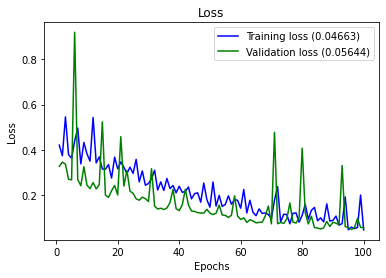

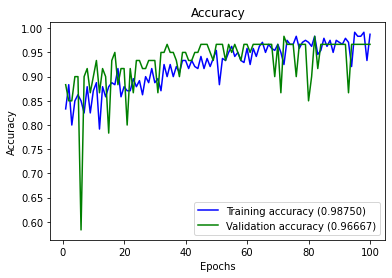

In [119]:
plot_history(history)

### TASK 2
Download the mnist dataset as shown below. If it fails you can download it from: <a href="http://www.phy.bme.hu/~torok/mnist_784.csv">http://www.phy.bme.hu/~torok/mnist_784.csv</a>.

 * Recognize the numbers using CNN. Print the CNN features.
 * Draw numbers by hand and try to recognize it by the network.

In [140]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [141]:
x_train.shape

(60000, 28, 28)

In [142]:
# Get every 10th picture
x_train = x_train[::10,:,:]
y_train = y_train[::10]
x_test = x_test[::10,:,:]
y_test = y_test[::10]

In [143]:
classifier = Sequential()
# Convolution layer, with 32 random 3x3 kernels
c1 = Conv2D(32, (3,3), padding='same', input_shape = (28, 28, 1), activation = 'relu')
c2 = Conv2D(32, (3,3), padding='same', activation = 'relu')
c3 = Conv2D(32, (3,3), padding='same', activation = 'relu')
classifier.add(c1)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(c2)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(c3)
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))
classifier.add(Flatten()) 
w1 = Dense(units = 25, activation = 'relu')
w2 = Dense(units = 10, activation = 'softmax')
classifier.add(w1)
classifier.add(Dropout(0.5)) 
classifier.add(w2)
classifier.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 3, 3, 32)       

In [144]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [145]:
history = classifier.fit(x_train, y_train, batch_size=40, epochs=50, verbose=1, 
                   validation_data=(x_test, y_test))

Epoch 1/50
150/150 [==============================] - 8s 49ms/step - loss: 3.5488 - accuracy: 0.1143 - val_loss: 2.3024 - val_accuracy: 0.1150
Epoch 2/50
150/150 [==============================] - 8s 57ms/step - loss: 2.3170 - accuracy: 0.1235 - val_loss: 2.2102 - val_accuracy: 0.1250
Epoch 3/50
150/150 [==============================] - 7s 47ms/step - loss: 2.2018 - accuracy: 0.1790 - val_loss: 1.8088 - val_accuracy: 0.3800
Epoch 4/50
150/150 [==============================] - 7s 46ms/step - loss: 2.0297 - accuracy: 0.2680 - val_loss: 1.5574 - val_accuracy: 0.5000
Epoch 5/50
150/150 [==============================] - 7s 47ms/step - loss: 1.8120 - accuracy: 0.3630 - val_loss: 1.3114 - val_accuracy: 0.6810
Epoch 6/50
150/150 [==============================] - 7s 46ms/step - loss: 1.6466 - accuracy: 0.4257 - val_loss: 1.1406 - val_accuracy: 0.7460
Epoch 7/50
150/150 [==============================] - 7s 48ms/step - loss: 1.4607 - accuracy: 0.4968 - val_loss: 0.8186 - val_accuracy: 0.8430

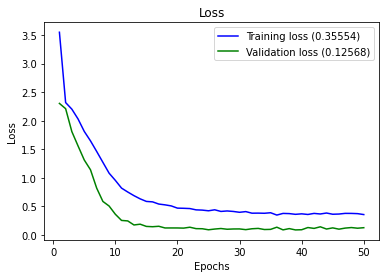

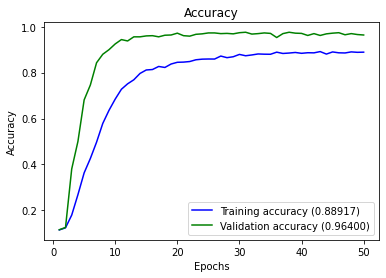

In [146]:
plot_history(history)

In [169]:
img = np.reshape(cv2.cvtColor(matplotlib.image.imread("number6.jpg"), cv2.COLOR_RGB2GRAY),(28,28,1))
images = np.array([255 - img])
classes = classifier.predict(images)
print("Prediction:",classes)
print("Predict classes:", classes.argmax(axis=1))

1/1 [==============================] - 0s 48ms/step
Prediction: [[1.7042446e-07 9.8564275e-11 7.1210602e-14 6.1126996e-16 1.4416389e-09
  3.4931651e-04 9.9965060e-01 1.3997559e-22 1.7759753e-08 7.0848301e-15]]
Predict classes: [6]


### Task 3
The airline-passengers.csv contains dates (one month per line) and passenger count. You may disregard the date and just care about the passenger count.

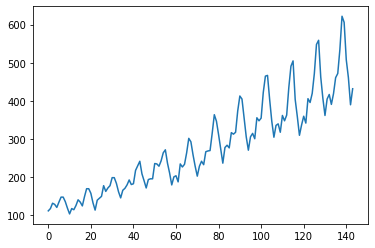

In [5]:
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
airdata_ = dataframe.values
airdata = airdata_.reshape(-1)
plt.plot(airdata)

### Task 3 (cont)
In the above figure you can see the yearly periodicity of the air travel as well as its increse (pre COVID data!)
We would like to predict the the next data point from `K` previous data points. So the input data is two three  dimensional, the first dimension is for the different data points, the second will have a dimension of `1` since we have one data per month, the third dimensino will be `K` long for the data in the previous months.

 1. The number of data points is `L`
 * Create the `(L-K,1,K)` shapes input data, where the `i`th is datapoint is `[airdata[i:i+K]]`
 * The output is the next airdata point. e.g. for the `i`th datapoint it is `airdata[i+K]`
 * Cut the data into 2/3 train and 1/3 test part
 * Create a convolutional neural network. The first layer should be a one dimensional convolutional layer `Conv1D`
 * Before the dense layers flatten the data using a `Flatten` layer
 * Test the prediction on the test data with `K=8, 12, 16`
 * Test the prediction by using the prediction as the `K`th point of the input data. E.g if the input data is in `x` with `x.shape = (1,K)`. Let `y` be the prediction ofr this input, then the new input shall be:
 `x[0][:-1] = x[0][1:]` (shift data in `x` to the left by one) and `x[0][-1] = y` (add the last output as the last data point of the next input)

In [6]:
scaler = MinMaxScaler()

data = scaler.fit_transform(airdata.reshape((len(airdata), 1)))
data = data.reshape(-1)

In [7]:
def get_data_points(data, K):
  data_points = []
  for i in range(0, len(data) - K):
    data_points.append([data[i:i+K]])

  return np.array(data_points)

In [8]:
def train_test_split(data, data_points, K):
  train_size = round(len(data_points) * 2 / 3)

  x = data_points
  y = data[K:]

  train_x = data_points[:train_size]
  test_x = data_points[train_size:]
  train_y = y[:train_size]
  test_y = y[train_size:]

  return (train_x, test_x), (train_y, test_y)

In [9]:
K = 12

In [10]:
data_points = get_data_points(data, K)
data_points.shape

(132, 1, 12)

In [11]:
(train_x, test_x), (train_y, test_y) = train_test_split(data, data_points, K)

train_x.shape

(88, 1, 12)

In [12]:
test_x.shape, test_y.shape

((44, 1, 12), (44,))

In [13]:
classifier = Sequential()
c1 = Conv1D(20, 3, padding='same', input_shape = (1,K), activation = 'relu')
classifier.add(c1)
classifier.add(Flatten()) 
# w1 = Dense(units = 50, activation = 'relu')
w2 = Dense(units = 1, activation = 'relu')
# classifier.add(w1)
classifier.add(w2)
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 20)             740       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 761
Trainable params: 761
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
history = classifier.fit(train_x, train_y, batch_size=20, epochs=500, verbose=1, 
                   validation_data=(test_x, test_y))

Epoch 1/500
5/5 [==============================] - 1s 34ms/step - loss: 3.0906e-04 - val_loss: 0.0014
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 2.7687e-04 - val_loss: 0.0014
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 2.6866e-04 - val_loss: 0.0014
Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 2.7803e-04 - val_loss: 0.0014
Epoch 5/500
5/5 [==============================] - 0s 8ms/step - loss: 2.8017e-04 - val_loss: 0.0014
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 2.7433e-04 - val_loss: 0.0013
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 2.4334e-04 - val_loss: 0.0011
Epoch 8/500
5/5 [==============================] - 0s 8ms/step - loss: 2.2888e-04 - val_loss: 0.0012
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3944e-04 - val_loss: 0.0011
Epoch 10/500
5/5 [==============================] - 0s 13ms/step - loss: 2.3767e-04 - va

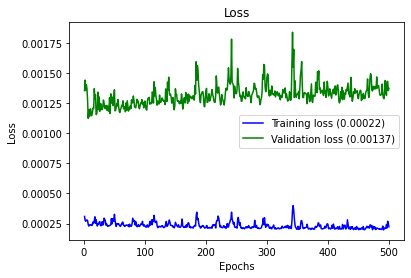

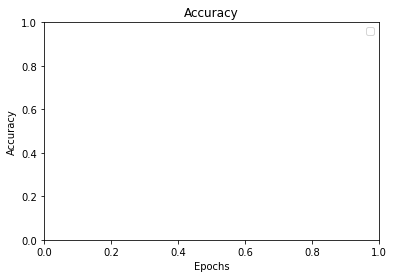

In [26]:
plot_history(history)

3/3 [==============================] - 0s 4ms/step


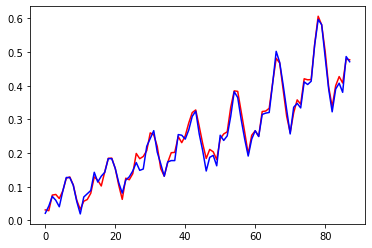

In [27]:
plt.plot(classifier.predict(train_x), 'r-')
plt.plot(train_y, 'b-')

2/2 [==============================] - 0s 6ms/step


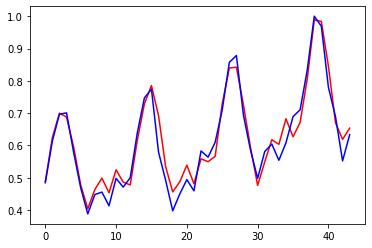

In [28]:
plt.plot(classifier.predict(test_x), 'r-')
plt.plot(test_y, 'b-')

In [37]:
print(test_x.shape)
print(np.array([test_x[0]]).shape)
# print(classifier.predict([]).shape)

(44, 1, 12)
(1, 1, 12)


In [50]:
N_predictions = 250

model_predictions = test_x[0].flatten().tolist()
input_data = test_x[0]

for i in range(N_predictions):
  pred = classifier.predict(np.array([input_data]))

  input_data[0][:-1] = input_data[0][1:]
  input_data[0][-1] = pred[0][0]

  model_predictions.append(pred[0][0])

1/1 [==============================] - 0s 18ms/step


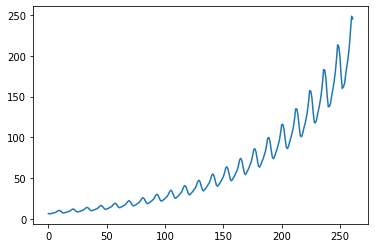

In [51]:
plt.plot(model_predictions)